Code Assistant Agent Design Overview

Architecture and Approach:
This code assistant agent is designed using a graph-based architecture with LangGraph to create a robust,
iterative code generation and validation system. The agent uses Mistral's large language model for code
generation and implements a self-correcting mechanism through multiple attempts.

Key Components:
1. State Management: Uses GraphState to track conversation history, code generations, error states, and
   iteration counts.
2. Code Generation: Structured output generation using Pydantic models to ensure consistent code formatting
   with imports, main code, and descriptions.
3. Validation Pipeline: Two-stage validation checking both imports and code execution separately to provide
   specific feedback.
4. Output Capture: Implements stdout redirection to capture both code execution results and print statements.
5. Efficient memory Management by keeping the original user question, most recent and relevant context.

Design Assumptions:
- Code solutions should be self-contained and executable
- Maximum 3 iterations for self-correction to prevent infinite loops
- User questions will be primarily focused on Python programming tasks
- Code solutions should include necessary imports and complete implementation

Potential Improvements:
1. Enhanced Error Handling:
   - Add more granular error categorization
   - Implement specific strategies for different types of errors
   - Add syntax validation before execution

2. Safety and Security:
   - Implement sandboxed code execution
   - Add timeout mechanisms for long-running code
   - Add input validation and code sanitization

3. Expanded Capabilities:
   - Support for multiple programming languages
   - Add unit test generation
   - Add memory of previous successful solutions

4. User Experience:
   - Add progress indicators for long-running operations
   - Implement interactive debugging
   - Add code complexity analysis

5. Performance:
   - Implement caching for common solutions
   - Add parallel validation checks
   - Optimize model prompting for faster responses

This implementation focuses on creating a reliable foundation for code generation with
built-in validation and self-correction capabilities, while maintaining extensibility for future improvements.

In [ ]:
! pip install -U langchain_community langchain-mistralai langchain langgraph

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

### LLM

We'll use the Mistral API and mistral-large-latest model, which support tool use!

In [6]:
import os

os.environ["TOKENIZERS_PARALLELISM"] = "true"
mistral_api_key = os.getenv("MISTRAL_API_KEY")

## Code Generation


In [8]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_mistralai import ChatMistralAI

mistral_model = "mistral-large-latest"
llm = ChatMistralAI(model=mistral_model, temperature=0)

# Prompt
code_gen_prompt_claude = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a coding assistant. Ensure any code you provide can be executed with all required imports and variables \n
            defined. Structure your answer: 1) a prefix describing the code solution, 2) the imports, 3) the functioning code block.
            \n Here is the user question:""",
        ),
        ("placeholder", "{messages}"),
    ]
)


# Data model
class code(BaseModel):
    """Code output"""

    prefix: str = Field(description="Description of the problem and approach")
    imports: str = Field(description="Code block import statements")
    code: str = Field(description="Code block not including import statements")
    description = "Schema for code solutions to answer users questions"


code_gen_chain = llm.with_structured_output(code, include_raw=False)

## State

In [9]:
from typing import Annotated, TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        error : Binary flag for control flow to indicate whether test error was tripped
        messages : With user question, error messages, reasoning
        generation : Code solution
        iterations : Number of tries
    """

    error: str
    messages: Annotated[list[AnyMessage], add_messages]
    generation: str
    iterations: int

## Graph

In [11]:
import uuid
from langchain_core.pydantic_v1 import BaseModel, Field

max_iterations = 3 #number of retry


# Nodes
def generate(state: GraphState):
    """
    Generate a code solution

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation
    """

    print("---GENERATING CODE SOLUTION---")

    # State
    messages = state["messages"]
    iterations = state["iterations"]

    code_solution = code_gen_chain.invoke(messages)
    messages += [
        (
            "assistant",
            f"Here is my attempt to solve the problem: {code_solution.prefix} \n Imports: {code_solution.imports} \n Code: {code_solution.code}",
        )
    ]

    iterations = iterations + 1
    return {"generation": code_solution, "messages": messages, "iterations": iterations}


def code_check(state: GraphState):
    """
    Check code

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, error
    """

    print("---CHECKING CODE---")

    # State
    messages = state["messages"]
    code_solution = state["generation"]
    iterations = state["iterations"]

    # Keeping only the original user input and last 3 responses if messages exceed this limit
    if len(messages) > 7:  # 7 = 1 user input + 3 pairs of (assistant response + error message)
        # original user input
        original_input = messages[0]

        # Get the last 6 messages
        last_messages = messages[-6:]

        # Reconstructing messages with original input + last messages
        messages = [original_input] + last_messages
        print("---TRIMMED MESSAGE HISTORY---")

    imports = code_solution.imports
    code = code_solution.code

    # Check imports
    try:
        exec(imports)
    except Exception as e:
        print("---CODE IMPORT CHECK: FAILED---")
        error_message = [
            (
                "user",
                f"Your solution failed the import test. Here is the error: {e}. Reflect on this error and your prior attempt to solve the problem. (1) State what you think went wrong with the prior solution and (2) try to solve this problem again. Return the FULL SOLUTION. Use the code tool to structure the output with a prefix, imports, and code block:",
            )
        ]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    # Check execution
    try:
        combined_code = f"{imports}\n{code}"
        print(f"CODE TO TEST: {combined_code}")

        #shared scope for exec
        global_scope = {}
        exec(combined_code, global_scope)
    except Exception as e:
        print("---CODE BLOCK CHECK: FAILED---")
        error_message = [
            (
                "user",
                f"Your solution failed the code execution test: {e}) Reflect on this error and your prior attempt to solve the problem. (1) State what you think went wrong with the prior solution and (2) try to solve this problem again. Return the FULL SOLUTION. Use the code tool to structure the output with a prefix, imports, and code block:",
            )
        ]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    # No errors
    final_message = [
            (
                "user",
                f"Above is my final attempt to solve the problem, generate the final response with description of the problem and above final approach. Don't mentation any above errors which we got earlier.",
            )
        ]
    messages += final_message
    print("---NO CODE TEST FAILURES---")
    return {
        "generation": code_solution,
        "messages": messages,
        "iterations": iterations,
        "error": "no",
    }

### Conditional edges

def decide_to_finish(state: GraphState):
    """
    Determines whether to finish.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """
    error = state["error"]
    iterations = state["iterations"]

    if error == "no" or iterations == max_iterations:
        print("---DECISION: FINISH---")
        return "generate_final_response"
    else:
        print("---DECISION: RE-TRY SOLUTION---")
        return "generate"


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

In [28]:
import sys
from io import StringIO
from contextlib import redirect_stdout

def generate_final_response(state: GraphState):
    """
    Generate a code solution

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, error
    """

    print("---GENERATING FINAL RESPONSE---")

    # State
    messages = state["messages"]
    iterations = state["iterations"]


    code_solution = code_gen_chain.invoke(messages)

    imports = code_solution.imports
    code = code_solution.code

    # Buffer to capture output
    output_buffer = StringIO()

    try:
        with redirect_stdout(output_buffer):
            combined_code = f"{imports}\n{code}"
            global_scope = {}
            exec(combined_code, global_scope)

        # Get the captured output
        result = output_buffer.getvalue()
        if not result:
            result = "Code executed successfully but produced no output"

    except Exception as e:
        result = f"Error occurred: {str(e)}"

    finally:
        output_buffer.close()

    messages += [
        (
            "assistant",
            f"{code_solution.prefix} \n"
            f"{code_solution.imports} \n"
            f"Code: {code_solution.code} \n\n"
            f"Test output: {result}",
        )
    ]

    return {
        "generation": code_solution,
        "messages": messages,
        "iterations": iterations,
        "error": "no",
    }

In [20]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START

builder = StateGraph(GraphState)

# Define the nodes
builder.add_node("generate", generate)  # generation solution
builder.add_node("check_code", code_check)  # check code
builder.add_node("generate_final_response", generate_final_response) #generate_final_response

# Build graph
builder.add_edge(START, "generate")
builder.add_edge("generate", "check_code")
builder.add_conditional_edges(
    "check_code",
    decide_to_finish,
    {
        "generate_final_response": "generate_final_response",
        "generate": "generate",
    },
)
builder.add_edge("generate_final_response", END)

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

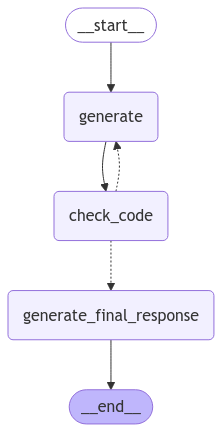

In [21]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

In [22]:
thread_id = str(uuid.uuid4())
config = {
    "configurable": {
        "thread_id": thread_id,
    }
}

In [25]:
def ask():
  while True:
    question=input("Ask a question or write exit to quit! : ")
    if question.lower() == "exit":
      break
    resp = graph.invoke({"messages": [("user", question)], "iterations": 3}, config)
    print(f"\n \n")
    print(resp['messages'][-1].content)

In [26]:
ask()

Ask a question or write exit to quit! : write the code to check if word MADAM is palindrome or not
---GENERATING CODE SOLUTION---
---CHECKING CODE---
CODE TO TEST: 
def is_palindrome(word):
    # Remove any spaces and convert to lowercase
    word = word.replace(" ", "").lower()
    # Check if the word is equal to its reverse
    return word == word[::-1]

# Test the function with the word 'MADAM'
word = 'MADAM'
if is_palindrome(word):
    print(f'The word {word} is a palindrome.')
else:
    print(f'The word {word} is not a palindrome.')
The word MADAM is a palindrome.
---NO CODE TEST FAILURES---
---DECISION: FINISH---
---GENERATING FINAL RESPONSE---

 

To determine if the word 'MADAM' is a palindrome, we need to check if it reads the same backward as forward. Here's a step-by-step approach to solve this problem: 
 
Code: def is_palindrome(word):
    # Remove any spaces and convert to lowercase
    word = word.replace(" ", "").lower()
    # Check if the word is equal to its reverse
  

In [29]:
ask()

Ask a question or write exit to quit! : "Find the user with the highest total transaction amount from the CSV
---GENERATING CODE SOLUTION---
---CHECKING CODE---
CODE TO TEST: import pandas as pd
def find_highest_transaction_user(csv_file):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file)
    
    # Group by user and sum the transaction amounts
    user_totals = df.groupby('user_id')['transaction_amount'].sum()
    
    # Find the user with the highest total transaction amount
    highest_transaction_user = user_totals.idxmax()
    highest_transaction_amount = user_totals.max()
    
    return highest_transaction_user, highest_transaction_amount

# Example usage
csv_file = 'transactions.csv'
user, amount = find_highest_transaction_user(csv_file)
print(f'The user with the highest total transaction amount is User ID: {user} with a total amount of: {amount}')
---CODE BLOCK CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---
---CHECKING COD